# Risk Evaluation for Aviation Division Expansion

## Overview

This analysis evaluates aviation accident data to identify the lowest-risk airplanes for commercial and private enterprises to provide actionable insights for the company's new aviation division to guide aircraft purchasing decisions.

## Business Understanding

The company is entering the aviation industry, will be focusing on operating airplanes for commercial and private enterprises. As a new player, it aims to minimize risks—safety (accidents/fatalities). This analysis will leverage historical accident data to identify the safest airplanes for these uses. Insights will guide the head of the new aviation division in making secure, cost-effective aircraft purchasing decisions.

In [1]:
# Imports here
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Data Understanding

The dataset contains aviation accident records, which will be used to identify airplanes with the lowest safety risks, the following steps explore the dataset’s structure, content, and quality to understand its potential for risk analysis.


In [2]:
# 1. Load dataset
df = pd.read_csv('Data/AviationData.csv', encoding='latin-1', low_memory=False)

# 2. Preview data
print("************ Head ************")
print(df.head())

print("\n\n************ Sample ************")
print(df.sample())

# 3. Explore Dataset Structure
print("\n\n************ Shape ************")
print(df.shape)

print("\n\n************ Columns ************")
print(df.columns.tolist())

print("\n\n************ Info ************")
print(df.info())

# 4. Missing data overview
print("\n\n===== Missing Data =====")
missing = df.isnull().sum()
print(missing[missing > 0].sort_values(ascending=False))

# 5. Summarize Numeric and Categorical Data
print("\n\n************ Describe (Numerical) ************")
print(df.describe())

print("\n\n************ Describe (Categorical) ************")
print(df.describe(include='object'))

# 6. Inspect categorical columns and their top categories
cat_cols = df.select_dtypes(include='object').columns
print("\n\n************ Categorical Columns ************")
print(cat_cols)

print("\n\n************ Top 5 Categories per Categorical Column ************")
for col in cat_cols:
    print(f"\n{col}:")
    print(df[col].value_counts(dropna=False).head(5))

# 7. Check for duplicates
print("\n\n************ Check for Duplicates ************")
print(f"Total Duplicates: {df.duplicated().sum()}")

# 8. Unique values of important columns to understand domain better
print("\n\n************ Unique Values ************")
print("Injury Severity:", df['Injury.Severity'].unique().tolist())
print("Aircraft Damage:", df['Aircraft.damage'].unique().tolist())
print("Weather Condition:", df['Weather.Condition'].unique().tolist())
print("Broad Phase of Flight:", df['Broad.phase.of.flight'].unique().tolist())
print("Purpose of Flight:", df['Purpose.of.flight'].unique().tolist())


************ Head ************
         Event.Id Investigation.Type Accident.Number  Event.Date  \
0  20001218X45444           Accident      SEA87LA080  1948-10-24   
1  20001218X45447           Accident      LAX94LA336  1962-07-19   
2  20061025X01555           Accident      NYC07LA005  1974-08-30   
3  20001218X45448           Accident      LAX96LA321  1977-06-19   
4  20041105X01764           Accident      CHI79FA064  1979-08-02   

          Location        Country   Latitude   Longitude Airport.Code  \
0  MOOSE CREEK, ID  United States        NaN         NaN          NaN   
1   BRIDGEPORT, CA  United States        NaN         NaN          NaN   
2    Saltville, VA  United States  36.922223  -81.878056          NaN   
3       EUREKA, CA  United States        NaN         NaN          NaN   
4       Canton, OH  United States        NaN         NaN          NaN   

  Airport.Name  ... Purpose.of.flight Air.carrier Total.Fatal.Injuries  \
0          NaN  ...          Personal         N

##### Key Observations
The dataset contains {df.shape[0]} records and {df.shape[1]} columns, covering accidents from 1948 to recent years, with key columns like 'Aircraft.Category' (to distinguish airplanes from helicopters), 'Make' and 'Model' (to identify aircraft), 'Injury.Severity' and 'Total.Fatal.Injuries' (to assess safety risks), and 'Broad.phase.of.flight' and 'Weather.Condition' (to analyze accident causes).
print(f"Significant missing data exists in 'Aircraft.Category' (56,602 missing), 'Broad.phase.of.flight' (27,165 missing), and injury columns (e.g., 11,401 missing for 'Total.Fatal.Injuries'), requiring cleaning in the next phase. Numerical summaries show most accidents have zero fatalities (mean 0.65, max 349), indicating non-fatal incidents dominate. Categorical summaries reveal common manufacturers (e.g., Cessna, Piper) and high-risk flight phases (e.g., Landing, Takeoff), which will guide the selection of low-risk aircraft. No duplicates ensure data integrity.

# Data Preparation

This section cleans and preprocesses the aviation accident dataset to ensure data quality for analyzing low-risk airplanes and comparing them to another aircraft type (e.g., helicopters). Steps include handling missing values, standardizing text, filtering for relevant aircraft categories and recent years, and creating derived columns for risk analysis.

In [3]:
# Standardize columns
df.columns = df.columns.str.strip().str.replace('.', '_').str.lower()

pd.set_option('display.max_rows', 2000)

# Select essential columns
selected_cols = [
    'event_id', 'event_date', 'make', 'model', 'aircraft_category',
    'engine_type', 'amateur_built', 'number_of_engines', 'purpose_of_flight',
    'schedule', 'aircraft_damage', 'injury_severity', 'total_fatal_injuries',
    'total_serious_injuries', 'total_minor_injuries', 'total_uninjured',
    'weather_condition', 'broad_phase_of_flight'
]
df = df[selected_cols]

# Fill missing data with defaults or placeholders
df['weather_condition'] = df['weather_condition'].fillna('UNK').str.upper()
df['broad_phase_of_flight'] = df['broad_phase_of_flight'].fillna('Unknown')
df[['total_fatal_injuries', 'total_serious_injuries', 'total_minor_injuries', 'total_uninjured']] = df[['total_fatal_injuries', 'total_serious_injuries', 'total_minor_injuries', 'total_uninjured']].fillna(0)


# Drop rows with missing critical data
critical_cols = ['aircraft_category', 'make', 'model', 'injury_severity', 'total_fatal_injuries']
df = df.dropna(subset=critical_cols)


# Filter rows by valid categories for aircraft damage and amateur built
valid_damage = ['Destroyed', 'Substantial', 'Minor']
df = df[df['aircraft_damage'].isin(valid_damage)]
df = df[df['amateur_built'].isin(['Yes', 'No'])]


injury_cols = ['total_fatal_injuries', 'total_serious_injuries',
               'total_minor_injuries', 'total_uninjured']
df[injury_cols] = df[injury_cols].fillna(0)


injury_cols = ['total_fatal_injuries', 'total_serious_injuries', 'total_minor_injuries', 'total_uninjured']
for col in injury_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# Standardize text columns
df['make'] = df['make'].str.upper().str.replace(r'[^A-Z0-9 ]', '', regex=True).str.strip()
df['model'] = df['model'].str.upper().str.replace(r'[^A-Z0-9 ]', '', regex=True).str.strip()
df['aircraft_category'] = df['aircraft_category'].str.upper().str.replace(r'[^A-Z0-9 ]', '', regex=True).str.strip()
df['weather_condition'] = df['weather_condition'].str.upper()

# Normalize 'make' names with mapping
normalize_make = {
   'AEROFAB INC.':  'AEROFAB INC',
    'AEROFAB':  'AEROFAB INC',
     'AERO SP Z O O GOBOSH': 'AERO SP ZOO',    
    'AERO SP Z O O': 'AERO SP ZOO',
 'AEROPRO CZ S R O': 'AEROPRO CZ', 
 'AIR TRACTOR INC': 'AIR TRACTOR',
 'AIR TRACTOR INC.': 'AIR TRACTOR',
 'AIRBUS HELICOPTERS': 'AIRBUS',
 'AIRBUS HELICOPTERS INC': 'AIRBUS',
 'AIRBUS Helicopters': 'AIRBUS',
 'AIRCRAFT MFG & DVLPMT CO':'AIRCRAFT MFG & DEVELOPMENT CO',
  'AIRPLANE FACTORY (PTY) LTD THE':'AIRPLANE FACTORY (PTY) LTD',
 'AMS Flight': 'AMS FLIGHT',
 'ANKESTAR, BRADLEY D.': 'ANKERSTAR BRADLEY D',
 'ANTONOV':'ANTONOVICH ANTON B',
     'AUTOGYRO': 'AUTOGYRO GMBH',
 'AVIAT':'AVIAT AIRCRAFT INC',
 'AVIAT AIRCRAFT':'AVIAT AIRCRAFT INC', 
 'AVIAT INC':'AVIAT AIRCRAFT INC',
 'AVIATE':'AVIAT AIRCRAFT INC',
'AEROTEK': 'AEROTEK INC',
 'AGUSTAWESTLAND PHILADELPHIA': 'AGUSTAWESTLAND PHILADELPHIA CO',
      'AERO VODOCHODY': 'AERO VODOCHODY WORKS',
 'AERO VODOCHODY AERO WORKS': 'AERO VODOCHODY WORKS',
 'AERO WORKS': 'AERO VODOCHODY WORKS',
    'AERONCA CHAMP': 'AERONCA CHAMPION',
 'AERO AT SP ZOO': 'AERO SP ZOO', 
'AEROSTAR S A': 'AEROSTAR SA',

 'AIRCRAFT MFG  DEV CO': 'AIRCRAFT MFG  DEVELOPMENT CO',
 'AIRCRAFT MFG  DEV CO AMD': 'AIRCRAFT MFG  DEVELOPMENT CO',

 'AIRBORNE WINDSPORT': 'AIRBORNE WINDSPORTS',

 'AIRBORNE WINDSPORTS LTD': 'AIRBORNE WINDSPORTS PTY LTD',

 'AIRPLANE FACTORY': 'AIRPLANE FACTORY PTY LTD',

     'AMERICAN CHAMPION': 'AMERICAN CHAMPION AIRCRAFT',
 'AMERICAN CHAMPION ACAC': 'AMERICAN CHAMPION AIRCRAFT',
 'AMERICAN CHAMPION AIRCRAFT': 'AMERICAN CHAMPION AIRCRAFT',
 'AMERICAN CHAMPION AIRCRAFT COR': 'AMERICAN CHAMPION AIRCRAFT',
 'AVIONS MUDRY ET CIE': 'AVIONS MUDRY CIE',
    
 'BEECH': 'BEECH AIRCRAFT CORPORATION',
 'BEECH AIRCRAFT': 'BEECH AIRCRAFT CORPORATION',
 'BEECH AIRCRAFT CORP': 'BEECH AIRCRAFT CORPORATION',
 'BEECHCRAFT': 'BEECH AIRCRAFT CORPORATION',
 'BEECHCRAFT CORPORATION': 'BEECH AIRCRAFT CORPORATION',

 'BELLTRANSWORLD HELICOPTER COR': 'BELLTRANSWORLD HELICOPTERS',
 'BENNET': 'BENNETT',

 'BOWER': 'BOWERS FLY BABY',
 'BOWERS': 'BOWERS FLY BABY',
 'BOWERS FLYBABY': 'BOWERS FLY BABY',
 'BRITISH AEROSPACE': 'BRITISH AIRCRAFT CORP',
 'BRITISH AIRCRAFT CORP BAC': 'BRITISH AIRCRAFT CORP',
 'BRITTENNORMAN': 'BRITTEN NORMAN',
    
 'BUCKEYE':'BUCKEYE AVIATION INC',
 'BUCKEYE AVIATION':'BUCKEYE AVIATION INC',
 
 'BUCKEYE INDUSTRIES':'BUCKEYE INDUSTRIES INC',
 'BURKHART GROB FLUGZEUGBAH':'BURKHART GROB',
 'BURKHART GROB FLUGZEUGBAU':'BURKHART GROB',
 'BURKHARTGROB':'BURKHART GROB',

   'C A TECNAM SRL': 'CA TECNAM SRL',
    
 'CENTRAL OHIO DRAGONFLY CLUB':'CENTRAL OHIO DRAGONFLY CLUB LLC',
 'CENTRAL OHIO DRAGONFLY CLUBLLC':'CENTRAL OHIO DRAGONFLY CLUB LLC',
    'CESSNA':'CESSNA AIRCRAFT COMPANY',
 'CESSNA AIRCRAFT':'CESSNA AIRCRAFT COMPANY',
 'CESSNA AIRCRAFT CO':'CESSNA AIRCRAFT COMPANY',
     'CGS':'CGS AVIATION LLC',
 'CGS AVIATION':'CGS AVIATION LLC',
  'CHRISTEN INDUSTRIES':'CHRISTEN INDUSTRIES INC',
  'CIRRUS':'CIRRUS DESIGN CORPORATION',
 'CIRRUS DESIGN':'CIRRUS DESIGN CORPORATION',
 'CIRRUS DESIGN CORP':'CIRRUS DESIGN CORPORATION',
 'CLARK':  'CLARKE COLIN',
 'CLARKE COLIN A':  'CLARKE COLIN',
    'COMMANDER': 'COMMANDER AIRCRAFT COMPANY',
 'COMMANDER AIRCRAFT CO': 'COMMANDER AIRCRAFT COMPANY',
'CONSOLIDATED  AERONAUTICS INC': 'CONSOLIDATED AERONAUTICS INC',
 'CONSOLIDATED AERO': 'CONSOLIDATED AERONAUTICS INC',
 'CONSOLIDATED AERONAUTICS': 'CONSOLIDATED AERONAUTICS INC',
     'CONTINENTAL':'CONTINENTAL COPTERS INC',
 'CONTINENTAL COPTERS':'CONTINENTAL COPTERS INC',
  'COSTRUZIONI AERONAUTICHE':'COSTRUZIONI AERONAUTICHE TECNA',
 'COSTRUZIONI AERONAUTICHETECNAM': 'COSTRUZIONI AERONAUTICHE TECNA',
  
 'CUB CRAFTER':'CUB CRAFTERS INC',
 'CUB CRAFTERS':'CUB CRAFTERS INC', 
 'CUBCRAFTER':'CUB CRAFTERS INC',
 'CUBCRAFTERS':'CUB CRAFTERS INC',
 'CUBCRAFTERS INC':'CUB CRAFTERS INC',
 'CULVER':'CULVER GLENN',
  'CURTISS': 'CURTISS MOSES',

 'CURTISSWRIGHT':'CURTISS WRIGHT',
 'CURTISWRIGHT':'CURTISS WRIGHT',
 'CZECH AIRCRAFT WORKS SPOL SRO':'CZECH AIRCRAFT WORKS',
    
 'CZECH SPORT AIRCRAFT':'CZECH SPORT AIRCRAFT AS',
 'CZECH SPORT AIRCRAFT A S':'CZECH SPORT AIRCRAFT AS',
  'AEROS': 'AEROS LTD',

 'AEROS LTDSKYRANGER AIRCRAFT': 'AEROS LTD',
     'AEROSPATIALE': 'AEROSPATIALE ALENIA',

 'AMATEUR BUILT': 'AMATEUR BUILT AIRCRAFT',
 'AMERICAN AIR RACING': 'AMERICAN AIR RACING LTD',
 'ARCTIC':'ARCTIC AIRCRAFT CO INC',
 'ARCTIC AIRCRAFT':'ARCTIC AIRCRAFT CO INC',
 
 
 'ARROWFALCON EXPORTERS INC':'ARROW FALCON EXPORTERS INC',
    'ATKINS': 'ATKINS JOHN',
 'BAE':'BAE SYSTEMS',
 
 'BAE SYSTEMS OPERATIONS LIMIT':'BAE SYSTEMS',
    
 'BORDELON':'BORDELON BRUCE',
 
 'DESTINY POWERED PARACHUTES':'DESTINY POWERED PARACHUTES LLC',
 
 'DG FLUGZEUGBAU': 'DG FLUGZEUGBAU GMBH',
 'DG FLUGZEUGBAU GMBH':'DG FLUGZEUGBAU GMBH',
 'DGFLUGZEUGBAU GMBH':'DG FLUGZEUGBAU GMBH',

    'DIAMOND':'DIAMOND AIRCRAFT INDUSTRY INC',
 'DIAMOND AICRAFT INDUSTRIES INC':'DIAMOND AIRCRAFT INDUSTRY INC',
 'DIAMOND AIRCRAFT':'DIAMOND AIRCRAFT INDUSTRY INC',
 'DIAMOND AIRCRAFT IND GMBH':'DIAMOND AIRCRAFT INDUSTRY INC',
 'DIAMOND AIRCRAFT IND INC':'DIAMOND AIRCRAFT INDUSTRY INC',
 'DIAMOND AIRCRAFT INDUSTRIES':'DIAMOND AIRCRAFT INDUSTRY INC',
 'DIAMOND AIRCRAFT INDUSTRIES IN':'DIAMOND AIRCRAFT INDUSTRY INC',
 'EMBRAER':'EMBRAER AIRCRAFT',
 'EMBRAER EXECUTIVE AIRCRAFT INC':'EMBRAER AIRCRAFT',
    
 'EMBRAER S A': 'EMBRAER SA',

    
 'EUROCOPTER':'EUROCOPTER DEUTSCHLAND GMBH',
 'EUROCOPTER DEUTSCHLAND':'EUROCOPTER DEUTSCHLAND GMBH',
 'EVEKTOR':'EVEKTOR AEROTECHNIC', 
 'EVEKTOR AEROTECHNIK':'EVEKTOR AEROTECHNIC',
 'EVEKTOR AEROTECHNIK AS':'EVEKTOR AEROTECHNIC',
 'EVEKTORAEROTECHNIK':'EVEKTOR AEROTECHNIC',
 'EVEKTORAEROTECHNIK AS':'EVEKTOR AEROTECHNIC',
    
 'GATES LEAR JET':'GATES LEARJET CORPORATION',
 'GATES LEARJET':'GATES LEARJET CORPORATION',
 'GATES LEARJET CORP':'GATES LEARJET CORPORATION',
 
 'GLASAIR':'GLASAIR AVIATION USA LLC',
 'GLASAIR AVIATION LLC':'GLASAIR AVIATION USA LLC',
 'GRUMMAN':'GRUMMAN AIRCRAFT ENG CORP',
 'GRUMMAN ACFT ENG':'GRUMMAN AIRCRAFT ENG CORP',
 'GRUMMAN ACFT ENG COR':'GRUMMAN AIRCRAFT ENG CORP',
 'GRUMMAN ACFT ENG CORSCHWEIZER':'GRUMMAN AIRCRAFT ENG CORP',
 'GRUMMAN AIRCRAFT':'GRUMMAN AIRCRAFT ENG CORP',
 'GRUMMAN AIRCRAFT CORSCHWEIZER':'GRUMMAN AIRCRAFT ENG CORP',    
 'GULFSTREAM AM CORP COMM DIV':'GULFSTREAM AMERICAN CORP',
 'GULFSTREAM AMERICAN':'GULFSTREAM AMERICAN CORP'
}
df['make'] = df['make'].replace(normalize_make).fillna('UNKNOWN')

# Map damage severity for scoring
damage_map = {'Minor': 1, 'Substantial': 2, 'Destroyed': 3}
df['damage_severity'] = df['aircraft_damage'].map(damage_map)

# Convert injury columns to numeric and fill missing
df['total_fatal_injuries'] = pd.to_numeric(df['total_fatal_injuries'], errors='coerce').fillna(0).astype(int)
df['total_serious_injuries'] = pd.to_numeric(df['total_serious_injuries'], errors='coerce').fillna(0).astype(int)
df['total_minor_injuries'] = pd.to_numeric(df['total_minor_injuries'], errors='coerce').fillna(0).astype(int)
df['total_uninjured'] = pd.to_numeric(df['total_uninjured'], errors='coerce').fillna(0).astype(int)

# Calculate total injuries and occupants
df['total_injuries'] = df['total_fatal_injuries'] + df['total_serious_injuries'] + df['total_minor_injuries']
df['total_occupants'] = df['total_injuries'] + df['total_uninjured']

#Data preparation
This section cleans and preprocesses the aviation accident dataset to ensure data quality for identifying low-risk airplanes and determining the most suitable non-airplane aircraft type for commercial and private enterprises. Steps include handling missing values, standardizing text, filtering for recent years, and creating derived columns for risk analysis, allowing the data to guide investment decisions.


## Analysis and Results

The analysis focused on identifying low-risk airplanes and comparing them to helicopters. A risk score will be calculated for each aircraft type based on injury rate, fatality rate, and damage severity.

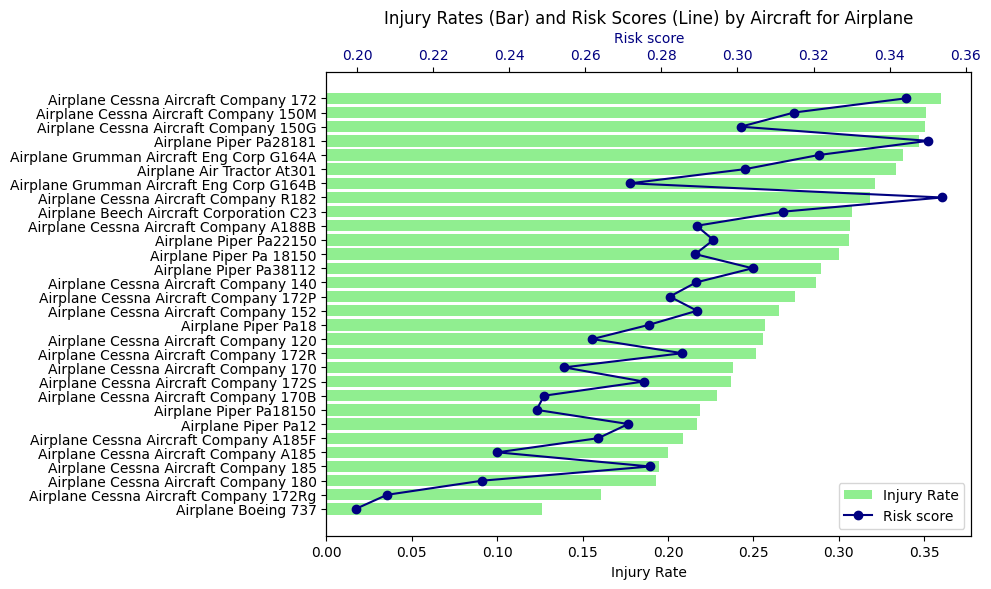

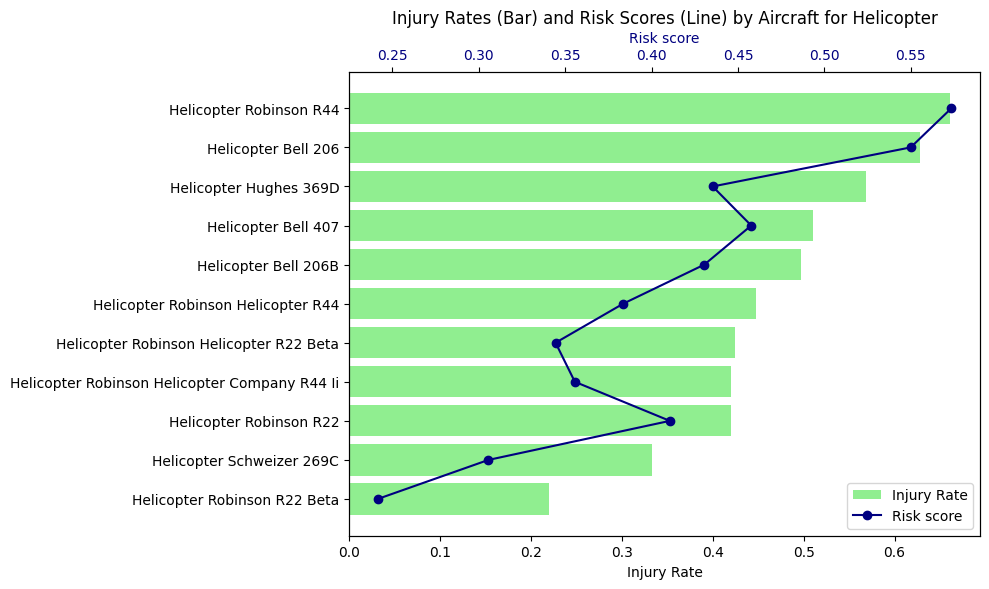

In [4]:

# Create aircraft_key for grouping: category_make_model
df['aircraft_key'] = (
    df['aircraft_category'].str.title().replace(' ', '', regex=False) + ' ' +
    df['make'].str.title().replace(' ', '', regex=False) + ' ' +
    df['model'].str.title().replace(' ', '', regex=False)
)

# Group by aircraft_key
grouped = df.groupby('aircraft_key').agg(
    event_count=('aircraft_key', 'count'),
    total_injuries=('total_injuries', 'sum'),
    total_fatalities=('total_fatal_injuries', 'sum'),
    total_uninjured=('total_uninjured', 'sum'),
    total_occupants=('total_occupants', 'sum'),
    avg_damage_severity=('damage_severity', 'mean')
).reset_index()


# Calculate group level rates
grouped['injury_rate'] = grouped['total_injuries'] / grouped['total_occupants']
grouped['fatality_rate'] = grouped['total_fatalities'] / grouped['total_occupants'] 
grouped['risk_score'] = (
    0.4 * grouped['injury_rate'] +
    0.4 * grouped['fatality_rate'] +
    0.2 * (grouped['avg_damage_severity'] / 3)
)

#filter groups with sufficient data 
min_event_count = 50
grouped = grouped[grouped['event_count'] >= min_event_count]  
 
 
import seaborn as sns
import matplotlib.pyplot as plt


def showInjuryRateAndRiskScorePlot(aircraft_type):
    plot_data = grouped[grouped['aircraft_key'].str.startswith(aircraft_type)].sort_values(by=['event_count','total_occupants','injury_rate', 'risk_score'], ascending=[False, False, False, False])
    plot_data = plot_data.sort_values(by='injury_rate')
    plot_data = plot_data.head(30)
    
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Bar plot for injury rate
    ax1.barh(plot_data['aircraft_key'], plot_data['injury_rate'], color='lightgreen', label='Injury Rate')
    ax1.set_xlabel('Injury Rate')
    ax1.set_title(f'Injury Rates (Bar) and Risk Scores (Line) by Aircraft for {aircraft_type}')

    # Line plot for risk rate (overlaid)
    ax2 = ax1.twiny()
    ax2.plot(plot_data['risk_score'], plot_data['aircraft_key'], color='navy', marker='o', label='Risk score')
    ax2.set_xlabel('Risk score', color='navy')
    ax2.tick_params(axis='x', labelcolor='navy')

    # Combine legends
    lines_labels = ax1.get_legend_handles_labels()
    lines_labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_labels[0] + lines_labels2[0], lines_labels[1] + lines_labels2[1], loc='lower right')

    plt.tight_layout()
    plt.savefig(f'injury_rates_risk_scores_{aircraft_type}.png')
    plt.show()

showInjuryRateAndRiskScorePlot('Airplane')   
showInjuryRateAndRiskScorePlot('Helicopter')   

The charts above show the injury rates (bars) and risk scores (line) for the top 30 low-risk airplanes and helicopters. The Airplane Boeing 737, Cessna aircraft company 172Rg and the helicopter Robinson R22 Beta and Schweizer 269C consistently show low injury rates and risk scores, making them ideal candidates.

### Business Recommendations
Based on the analysis, the following recommendations are provided to the head of the new aviation division:

#### Business Recommendation 1: Prioritize Boeing 737 for Airplane Operations
The Boeing 737 has the lowest injury rate (0.126193) and risk score (0.199628) among airplanes, reflecting a strong safety record for commercial use.
Purchase 2–3 newer models Boeing 737 or Airplane Cessna Aircraft Company 172Rg with updated safety systems, invest in extensive pilot and maintenance training, and begin with a small fleet for controlled operations.

#### Business Recommendation 2: Select Robinson R22 Beta for Helicopter Operations
The Robinson R22 Beta has the lowest injury rate (0.219780) and risk score (0.241442) among helicopters, suitable for training or light commercial roles like sightseeing.
Acquire R22 Betas, provide specialized pilot and maintenance training due to higher complexity, and limit initial use to low-risk environments.


## Conclusion

This analysis has enabled data-driven insights into aircraft safety profiles. Aircraft such as the Boeing 737 demonstrate high operational safety with many incidents resulting in no or minor injuries.

### Next Steps

1. Procure newer 737s and R22 Betas from reliable suppliers.
2. Develop comprehensive training for pilots and crews.
3. Analyze demand for commercial routes (737) and niche services (R22 Beta).
4. Implement a safety tracking system for ongoing risk assessment.